In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp

# 下面三个参数，在此练习中更新数值了哦
rho_axon = 7e-3  # Resistivity in ohm-meter
r_axon = 1e-6  # Radius in meters
l_comp = 3e-6  # Compartment length in meters

R_a = (rho_axon * l_comp) / (np.pi * r_axon**2)  # 6684.5

def temperature_correction(T): return 3.0 ** ((T - 6.3) / 10)
def alpha_m(V): return 0.1*(25-V) / (np.exp((25-V)/10) -1)
def beta_m(V): return 4*np.exp(-V / 18)
def alpha_n(V): return 0.01*(10 - V) / (np.exp((10 - V)/10) - 1)
def beta_n(V): return 0.125 * np.exp(-V / 80)
def alpha_h(V): return 0.07 * np.exp(-V/20)
def beta_h(V): return 1/ (np.exp((30 -V)/10) + 1)

In [2]:
def hh_gating(V, dt, m, n, h, T):

    a_m=1000*(2.5-100*V)/(np.exp(2.5-100*V)-1)
    b_m=4000*np.exp(-500*V/9)
    
    a_n=1000*(0.1-10*V)/(np.exp(1-100*V)-1)
    b_n=125*np.exp(-25*V/2)

    a_h=70*np.exp(-50*V)
    b_h=1000/(np.exp(3-100*V)+ 1)
    
    k = 3**(0.1*(T-6.3))

    #A and B for exponential solver
    B_m = a_m*k
    A_m = -a_m*k - b_m*k

    B_n = a_n*k
    A_n = -a_n*k - b_n*k

    B_h = a_h*k
    A_h = -a_h*k - b_h*k

    # Calculate gating variables m,n,h for future timestep for each neuron
    m_new = m*np.exp(A_m*dt) + B_m/A_m *(np.exp(A_m*dt) -1)
    n_new = n*np.exp(A_n*dt) + B_n/A_n *(np.exp(A_n*dt) -1)
    h_new = h*np.exp(A_h*dt) + B_h/A_h *(np.exp(A_h*dt) -1)

    return m_new, n_new, h_new


def ionic_currents(V, m_new, n_new, h_new):
    g_Na = 120e-3
    g_K = 36e-3    
    g_L = 0.3e-3  
    V_Na = 115e-3  
    V_K = -12e-3  
    V_L = 10.6e-3  

    I_Na = g_Na * m_new**3 * h_new * (V - V_Na)
    I_K = g_K * n_new**4 * (V - V_K)
    I_L = g_L * (V - V_L)

    I_ions = I_Na + I_K + I_L

    return I_ions


def create_matrix_C(n):
    C = np.diag([-2] * n) + np.diag([1] * (n - 1), k=1) + np.diag([1] * (n - 1), k=-1)
    C[0, 0] = C[-1, -1] = -1
    return C
C = create_matrix_C(100)


def hh_potential(V, dt, C_m, R_a, V_e, I_ions, C):
#     print(C.shape) # (100, 100)
#     print(V_e.shape) # (100,)
#     print((C*V_e).shape) #(100, 100)
#     print((C@V_e).shape) #(100, )
#     print(np.dot(C, V_e).shape) #(100, )
   
    n = len(V)

    A = np.eye(n) - ((dt / (C_m * R_a)) * C)

#     b = V + ((dt / C_m) * (I_stim - I_ions))
#     b = V + ((dt / C_m) * (1/R_a * C * V_e - I_ions))
    b = V + ((dt / C_m) * (- I_ions)) + (dt /(C_m*R_a))*(C@V_e)

    # Implicit Euler Solver for x (V_m_next)
    V_next = np.linalg.solve(A, b)

    return V_next


def hh_model(V_e, t_end, dt, T, V_rest, n_com, C):
    C_m = 1e-6  

    t = np.arange(0, t_end, dt)  

    # set matrix m, n, h, V, I_ions to save vectors
    V = np.zeros((n_com, len(t)))
    m = np.zeros((n_com, len(t)))
    n = np.zeros((n_com, len(t)))
    h = np.zeros((n_com, len(t)))
    I_ions = np.zeros((n_com, len(t)))

    # Set initial conditions for voltage and gating variables
    V[:, 0] = V_rest
    m0 = alpha_m(V[:, 0]) / (alpha_m(V[:, 0]) + beta_m(V[:, 0]))
    n0 = alpha_n(V[:, 0]) / (alpha_n(V[:, 0]) + beta_n(V[:, 0]))
    h0 = alpha_h(V[:, 0]) / (alpha_h(V[:, 0]) + beta_h(V[:, 0]))
    m[:, 0] = m0
    n[:, 0] = n0
    h[:, 0] = h0

    I_ions[:, 0] = ionic_currents(V[:,0], m[:, 0], n[:, 0], h[:, 0])

    for i in range(1, len(t)):
        # calculate the gating variables at t + dt 
        m_new, n_new, h_new = hh_gating(V[:,i-1], dt, m[:,i-1], n[:,i-1], h[:,i-1], T)
        m[:, i] = m_new
        n[:, i] = n_new
        h[:, i] = h_new

        I_ions[:, i] = ionic_currents(V[:,i-1], m[:, i], n[:, i], h[:, i])
        
        V[:,i] = hh_potential(V[:,i-1], dt, C_m, R_a, V_e[:,i], I_ions[:,i], C)

    return V, I_ions

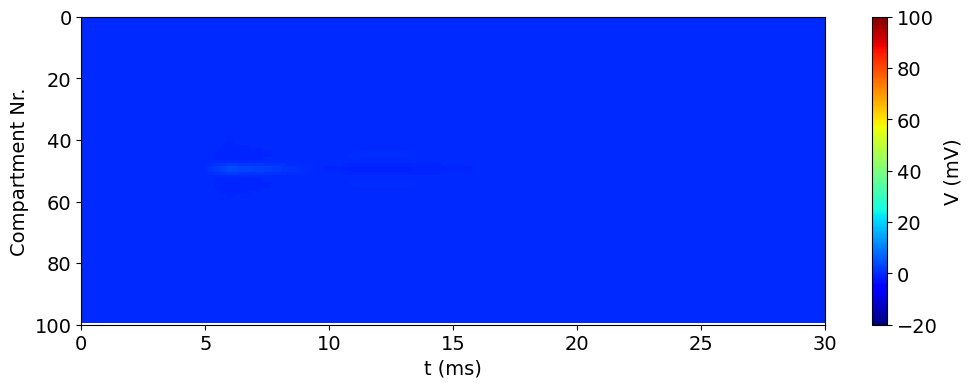

In [9]:
# 第一种电流情况
t_end  = 30e-3	# simulation duration in s
dt     = 25e-6	# time step in s
T      = 6.3
t = np.arange(0, t_end, dt)  
n = 100
V_rest = 0

rho_medium = 1  # Ohm.m
axon_length = 300e-6  # m
distance_to_axon = 10e-6  # m
center_of_axon = axon_length / 2
# positions = np.arange(0, axon_length + resolution, resolution)

V_e_1 = np.zeros((n, len(t))) # 100*1250
for i in range(0,100):
#     I_e_1[i, int(5e-3/dt):int(5e-3/dt)] = -0.05e-3
    I_e_1 = -0.05e-3
    r = np.sqrt((1.5e-6 + 3e-6*i - center_of_axon)**2 + distance_to_axon**2)
    V_e_1[i, int(5e-3/dt):int(6e-3/dt)] = (rho_medium * I_e_1) / (4 * np.pi * r)  # V_e 5ms-6ms的值就是没变/每个室内 不随时间改变，而随地点改变
    

# V_e_1替换I_stim_1 本练习就是把所有的I_stim换成V_e
V1, I1 = hh_model(V_e_1,t_end,dt,T, V_rest, n, C)  

plt.figure(figsize=(12, 4))
c = plt.pcolormesh(t*1e3, np.arange(n), V1*1e3, shading='auto', cmap='jet', vmin=-20, vmax=100)
plt.colorbar(c, label='V (mV)')
plt.xlabel('t (ms)')
plt.ylabel('Compartment Nr.')

plt.xticks(np.arange(0, 31, 5))
plt.yticks(np.arange(0, 101, 20))
plt.xlim(0, 30)
plt.ylim(0,100)
plt.gca().invert_yaxis()
plt.rcParams.update({'font.size': 14}) 
plt.show()

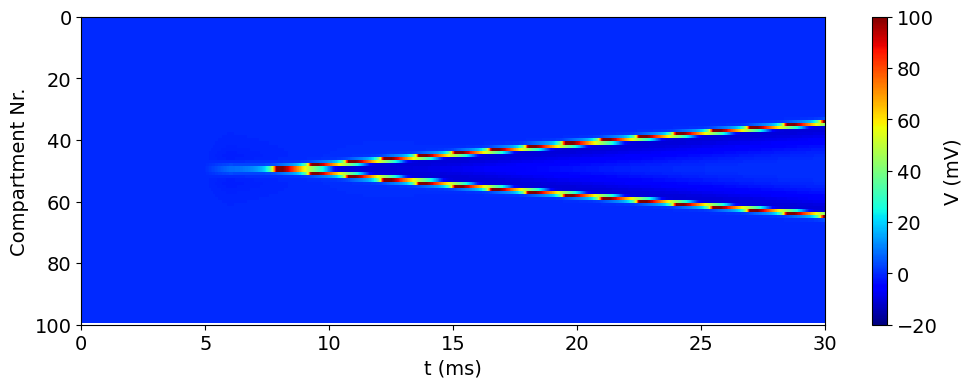

In [12]:
V_e_2 = np.zeros((n, len(t))) # 100*1250
for i in range(0,100):
    I_e_2 = -0.1e-3
    r = np.sqrt((1.5e-6 + 3e-6*i - center_of_axon)**2 + distance_to_axon**2)
    V_e_2[i, int(5e-3/dt):int(6e-3/dt)] = (rho_medium * I_e_2) / (4 * np.pi * r)  # V_e 5ms-6ms的值就是没变/每个室内 不随时间改变，而随地点改变
    
V2, I2 = hh_model(V_e_2,t_end,dt,T, V_rest, n, C)  

plt.figure(figsize=(12, 4))
c = plt.pcolormesh(t*1e3, np.arange(n), V2*1e3, shading='auto', cmap='jet', vmin=-20, vmax=100)
plt.colorbar(c, label='V (mV)')
plt.xlabel('t (ms)')
plt.ylabel('Compartment Nr.')

plt.xticks(np.arange(0, 31, 5))
plt.yticks(np.arange(0, 101, 20))
plt.xlim(0, 30)
plt.ylim(0,100)
plt.gca().invert_yaxis()
plt.rcParams.update({'font.size': 14}) 
plt.show()

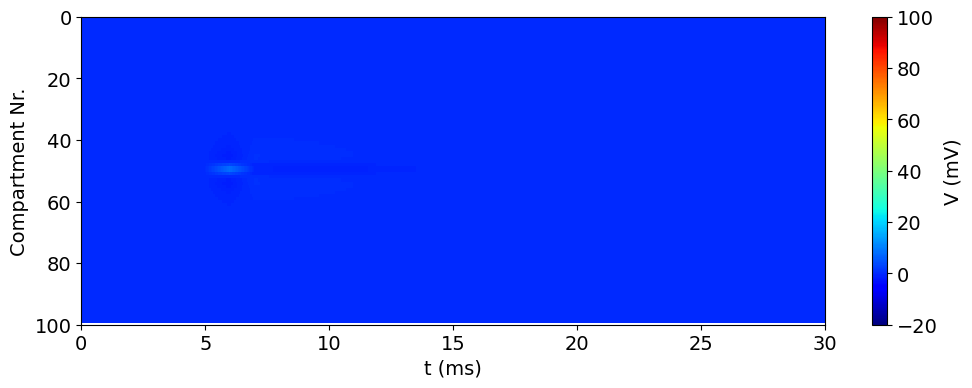

In [13]:
V_e_3 = np.zeros((n, len(t))) # 100*1250
for i in range(0,100):
    I_e_3 = -0.1e-3 # 5-6ms负的电流，6-7ms正的电流
    r = np.sqrt((1.5e-6 + 3e-6*i - center_of_axon)**2 + distance_to_axon**2)
    V_e_3[i, int(5e-3/dt):int(6e-3/dt)] = (rho_medium * I_e_3) / (4 * np.pi * r)  # V_e 5ms-6ms的值就是没变/每个室内 不随时间改变，而随地点改变
    V_e_3[i, int(6e-3/dt):int(7e-3/dt)] = (rho_medium * -I_e_3) / (4 * np.pi * r)
    
V3, I3 = hh_model(V_e_3,t_end,dt,T, V_rest, n, C)  

plt.figure(figsize=(12, 4))
c = plt.pcolormesh(t*1e3, np.arange(n), V3*1e3, shading='auto', cmap='jet', vmin=-20, vmax=100)
plt.colorbar(c, label='V (mV)')
plt.xlabel('t (ms)')
plt.ylabel('Compartment Nr.')

plt.xticks(np.arange(0, 31, 5))
plt.yticks(np.arange(0, 101, 20))
plt.xlim(0, 30)
plt.ylim(0,100)
plt.gca().invert_yaxis()
plt.rcParams.update({'font.size': 14}) 
plt.show()

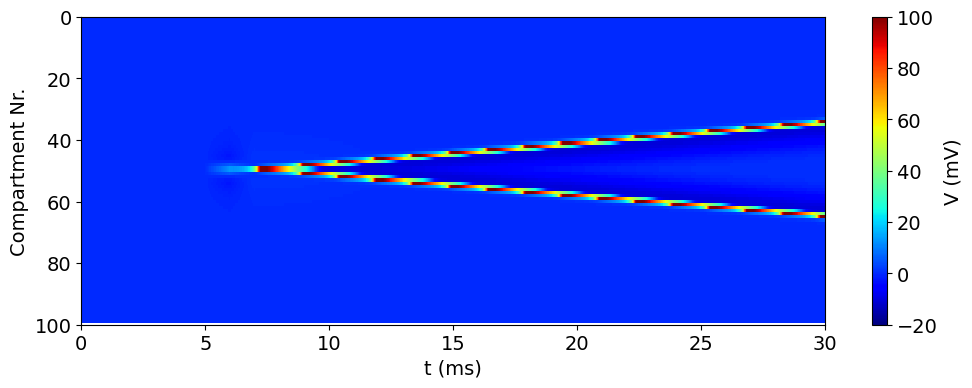

In [16]:
V_e_4 = np.zeros((n, len(t))) # 100*1250
for i in range(0,100):
    I_e_4 = -0.15e-3
    r = np.sqrt((1.5e-6 + 3e-6*i - center_of_axon)**2 + distance_to_axon**2)
    V_e_4[i, int(5e-3/dt):int(6e-3/dt)] = (rho_medium * I_e_4) / (4 * np.pi * r)  # V_e 5ms-6ms的值就是没变/每个室内 不随时间改变，而随地点改变
    V_e_4[i, int(6e-3/dt):int(7e-3/dt)] = (rho_medium * -I_e_4) / (4 * np.pi * r)
    
V4, I4 = hh_model(V_e_4,t_end,dt,T, V_rest, n, C)  

plt.figure(figsize=(12, 4))
c = plt.pcolormesh(t*1e3, np.arange(n), V4*1e3, shading='auto', cmap='jet', vmin=-20, vmax=100)
plt.colorbar(c, label='V (mV)')
plt.xlabel('t (ms)')
plt.ylabel('Compartment Nr.')

plt.xticks(np.arange(0, 31, 5))
plt.yticks(np.arange(0, 101, 20))
plt.xlim(0, 30)
plt.ylim(0,100)
plt.gca().invert_yaxis()
plt.rcParams.update({'font.size': 14}) 
plt.show()

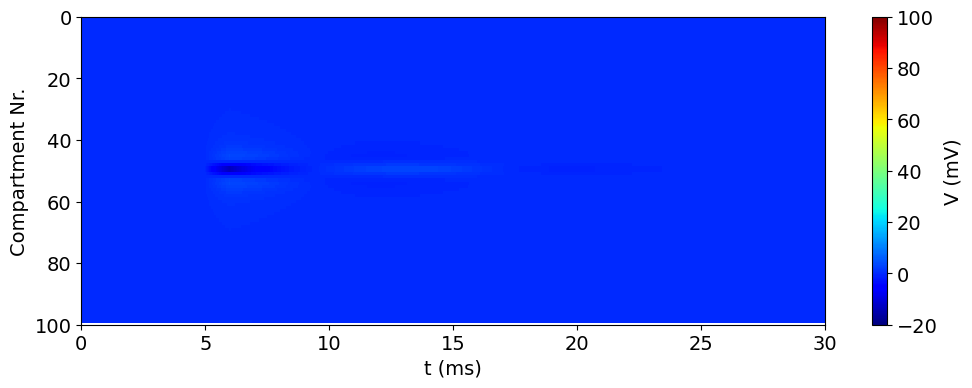

In [18]:
V_e_5 = np.zeros((n, len(t))) # 100*1250
for i in range(0,100):
    I_e_5 = 0.2e-3
    r = np.sqrt((1.5e-6 + 3e-6*i - center_of_axon)**2 + distance_to_axon**2)
    V_e_5[i, int(5e-3/dt):int(6e-3/dt)] = (rho_medium * I_e_5) / (4 * np.pi * r)  # V_e 5ms-6ms的值就是没变/每个室内 不随时间改变，而随地点改变
    
V5, I5 = hh_model(V_e_5,t_end,dt,T, V_rest, n, C)

plt.figure(figsize=(12, 4))
c = plt.pcolormesh(t*1e3, np.arange(n), V5*1e3, shading='auto', cmap='jet', vmin=-20, vmax=100)
plt.colorbar(c, label='V (mV)')
plt.xlabel('t (ms)')
plt.ylabel('Compartment Nr.')

plt.xticks(np.arange(0, 31, 5))
plt.yticks(np.arange(0, 101, 20))
plt.xlim(0, 30)
plt.ylim(0,100)
plt.gca().invert_yaxis()
plt.rcParams.update({'font.size': 14}) 
plt.show()

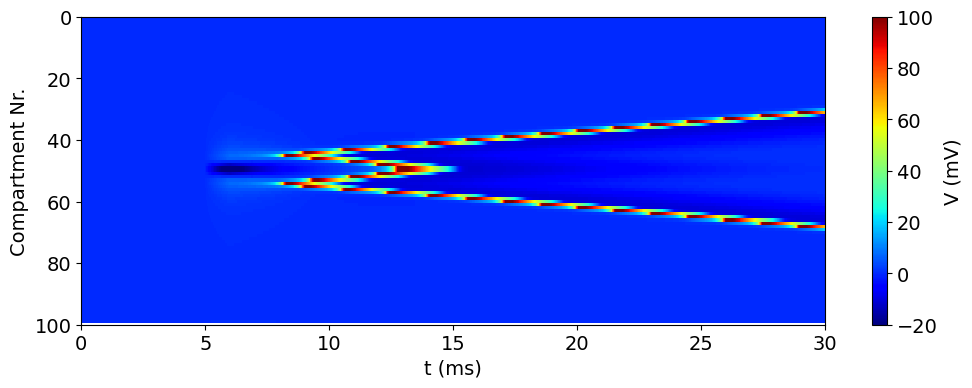

In [20]:
V_e_6 = np.zeros((n, len(t))) # 100*1250
for i in range(0,100):
    I_e_6 = 0.4e-3
    r = np.sqrt((1.5e-6 + 3e-6*i - center_of_axon)**2 + distance_to_axon**2)
    V_e_6[i, int(5e-3/dt):int(6e-3/dt)] = (rho_medium * I_e_6) / (4 * np.pi * r)  # V_e 5ms-6ms的值就是没变/每个室内 不随时间改变，而随地点改变
    
V6, I6 = hh_model(V_e_6,t_end,dt,T, V_rest, n, C)  

plt.figure(figsize=(12, 4))
c = plt.pcolormesh(t*1e3, np.arange(n), V6*1e3, shading='auto', cmap='jet', vmin=-20, vmax=100)
plt.colorbar(c, label='V (mV)')
plt.xlabel('t (ms)')
plt.ylabel('Compartment Nr.')

plt.xticks(np.arange(0, 31, 5))
plt.yticks(np.arange(0, 101, 20))
plt.xlim(0, 30)
plt.ylim(0,100)
plt.gca().invert_yaxis()
plt.rcParams.update({'font.size': 14}) 
plt.show()